# How to make API calls with Python a guided example

## Abstract

This notebook illustrates the process of making API calls with Python to retrieve data from standard REST APIs. The process usually follows the below framework:

- Finding the URL endpoint of the API and storing it in a variable
- Understanding what parameters are available (via the API homepage) and passing them to the URL
- Use of the requests library to pass the constructed query to the service
- Retrival of data in JSON format
- Serialisation into a Python dictionary
- Processing of the returned object for application needs.

## 1. Dependencies & modules imports

The code relies on the following libraries:
- requests (not installed by default -> to be installed by pip3)
- datetime (not installed by default -> to be installed by pip3)
- polars (not installed by default -> to be installed by pip3)
- seaborn (not installed by default -> to be installed by pip)
- json (part of stdlib)
- pprint (part of stdlib)


In [ ]:
# Cell magic - Making sure the required libraries are installed
! pip3 install requests datetime seaborn polars

In [1]:
# Imports
import requests # importing the requests library to make automated http calls
import json # importing json library to parse JSON object response -> part of standard lib
from datetime import datetime, timedelta # Importing library to get dates and calculate time deltas
import pprint # Importing library to pretty print Python dictionaries -> part of standard lib
import polars as pl # Tabular data frames
import seaborn as sns # Easy Charting

# 2. Example: Making API Call to WeatherAPI.com

In [2]:
# Setting up variables
## A. access tokens - This is the API key given by weatherapi.com
api_key = '<INSERTYOURKEY>'

## B. api endpoint
url = 'https://api.weatherapi.com/v1/forecast.json'

## C. Dates dictionary
### Creating a dictionary of dates for the next 5 days
today = datetime.today().date()

next_7_days = {
    'now': today.strftime('%Y-%m-%d'),
    'tomorrow': (today + timedelta(days=1)).strftime('%Y-%m-%d'),
    'in 2 days': (today + timedelta(days=2)).strftime('%Y-%m-%d'),
    'in 3 days': (today+ timedelta(days=3)).strftime('%Y-%m-%d'),
    'in 4 days': (today+ timedelta(days=4)).strftime('%Y-%m-%d'),
    'in 5 days': (today+ timedelta(days=5)).strftime('%Y-%m-%d')
}

## D. Cities List
cities = ['Paris', 'London', 'New York']

## E. Specifying Parameters to API
params = {'key': api_key, 'dt' : next_7_days['now'],'q': cities[0]}

In [ ]:
# Making a call directly to the WeatherAPI.com Api
with requests.get(url, params=params) as response:
  data =  response.json()  # Parse the JSON response into a Python dictionary
  pprint.pprint(data) # Pretty prints the python dictionary (otherwise would be displayed a one line)

# 3. Example: Making API Call to Alphavantage.co

To make an API call and request End of day prices (EOD) we can use what is called an "API End Point"

- In this case https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED
- We can then pass optional parameters to the URL via "parameters"
- we need to specify the type of data, API key etc...



Example of sample constructed URL to get price data for IBM

https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IBM&outputsize=full&apikey=demo

In [ ]:
import requests
import pprint

# In the below - replace the ticker with the stock ticker you want
##             - replace demo by your own API key (you can get one for free on Alphavantage)

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED'
params = {
    'symbol' : 'IBM',
    'outputsize' : 'full',
    'apikey' : 'demo'
}
# Making a call directly to the WeatherAPI.com Api
with requests.get(url, params=params) as response:
  data =  response.json()  # Parse the JSON response into a Python dictionary
  pprint.pprint(data) # Pretty prints the python dictionary (otherwise would be displayed a one line)

In [5]:
# Returned JSON object has two keys
data.keys()

dict_keys(['Meta Data', 'Time Series (Daily)'])

In [6]:
# To access time series data we drill down to the second key
## For IBM we seem to have quite a large range of dates
print(min(data['Time Series (Daily)'].keys()))
print(max((data['Time Series (Daily)'].keys())))

1999-11-01
2023-07-07


## 4. Transitioning from Dict to tabular data

In [ ]:
# Polars has superseeded Pandas for tabular data manipulation
# Pandas is optimized for single core used whereas polars is written Rust and optimized for multicores procs.

In [ ]:
# Upacking the dictonary returned by alpha vantage creating a list of dicts we can pass to polars:
rows = [{**{'date': date}, **values} for date, values in data['Time Series (Daily)'].items()]
rows

In [9]:
# By default dictionaries in Polars are ingested as strings
df = pl.DataFrame(rows)
df.head()

date,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
str,str,str,str,str,str,str,str,str
"""2023-07-07""","""131.78""","""133.855""","""131.75""","""132.08""","""132.08""","""2982738""","""0.0000""","""1.0"""
"""2023-07-06""","""133.235""","""133.9""","""131.55""","""132.16""","""132.16""","""3508083""","""0.0000""","""1.0"""
"""2023-07-05""","""133.32""","""134.31""","""132.59""","""134.24""","""134.24""","""2955870""","""0.0000""","""1.0"""
"""2023-07-03""","""133.42""","""134.35""","""132.87""","""133.67""","""133.67""","""1477149""","""0.0000""","""1.0"""
"""2023-06-30""","""134.69""","""135.03""","""133.425""","""133.81""","""133.81""","""4236677""","""0.0000""","""1.0"""


In [10]:
# Therefore the data type of each column needs to be specified separatly
## Specifying data types
## Specify the data types for columns
dtypes = {
    'date': pl.Date,
    '1. open': float,
    '2. high': float,
    '3. low': float,
    '4. close': float,
    '5. adjusted close': float,
    '6. volume': int,
    '7. dividend amount': float,
    '8. split coefficient': float
}

In [11]:
for col, dtype in dtypes.items():
  print(col)
  print(dtype)

date
Date
1. open
<class 'float'>
2. high
<class 'float'>
3. low
<class 'float'>
4. close
<class 'float'>
5. adjusted close
<class 'float'>
6. volume
<class 'int'>
7. dividend amount
<class 'float'>
8. split coefficient
<class 'float'>


In [12]:
# Cast columns to specified data types
for col, dtype in dtypes.items():
    if col == 'date':
        df = df.with_columns(pl.col(col).str.strptime(dtype, "%Y-%m-%d"))
    else:
        df = df.with_columns(pl.col(col).cast(dtype))

In [13]:
df.head()

date,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,f64,f64,f64,f64,f64,i64,f64,f64
2023-07-07,131.78,133.855,131.75,132.08,132.08,2982738,0.0,1.0
2023-07-06,133.235,133.9,131.55,132.16,132.16,3508083,0.0,1.0
2023-07-05,133.32,134.31,132.59,134.24,134.24,2955870,0.0,1.0
2023-07-03,133.42,134.35,132.87,133.67,133.67,1477149,0.0,1.0
2023-06-30,134.69,135.03,133.425,133.81,133.81,4236677,0.0,1.0


## 5. Charting with Seaborn in Python

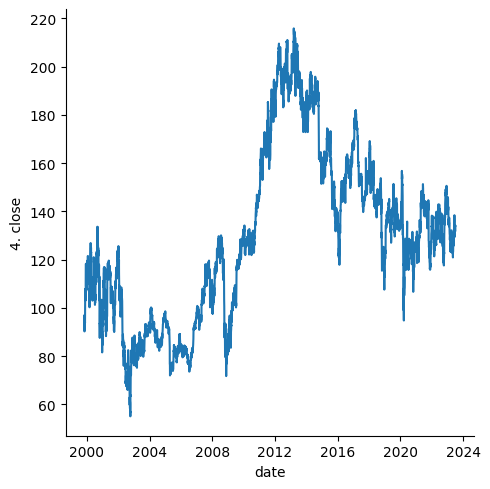

In [14]:
sns.relplot(
    data = df,
    x='date',
    y='4. close',
    kind = 'line')

# 6. Basic Data transforms

In [16]:
import numpy as np
# Introducing Stationarity in daily returns

# Sort the DataFrame by timestamps if it's not already sorted
df = df.sort("date")

# Calculate the natural logarithm return - note np.log() is ln WHILE np.log10 is log...
log_return = np.log(df['4. close']) - np.log(df['4. close'].shift(1))

# Add the logarithmic return as a new column
df = df.with_columns(log_return = log_return)
df.head()

/home/test/virtualenv/scrapbot/lib/python3.10/site-packages/polars/series/series.py:1141: RuntimeWarning: divide by zero encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


date,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,log_return
date,f64,f64,f64,f64,f64,i64,f64,f64,f64
1999-11-01,98.5,98.81,96.37,96.75,51.949021,9551800,0.0,1.0,null
1999-11-02,96.75,96.81,93.69,94.81,50.907356,11105400,0.0,1.0,-0.020255
1999-11-03,95.87,95.94,93.5,94.37,50.671102,10369100,0.0,1.0,-0.004652
1999-11-04,94.44,94.44,90.0,91.56,49.162298,16697600,0.0,1.0,-0.030229
1999-11-05,92.75,92.94,90.19,90.25,48.458906,13737600,0.0,1.0,-0.014411


In [17]:
#Summary stats.

df['log_return'].describe() # <-- fairly shit summary statistics - need to look for other package

# Love it that the share lost 16 pct in one day!

statistic,value
str,f64
"""count""",5958.0
"""null_count""",1.0
"""mean""",0.000052
"""std""",0.016588
"""min""",-0.16889
"""max""",0.113488
"""median""",0.000232
"""25%""",-0.007316
"""75%""",0.007607


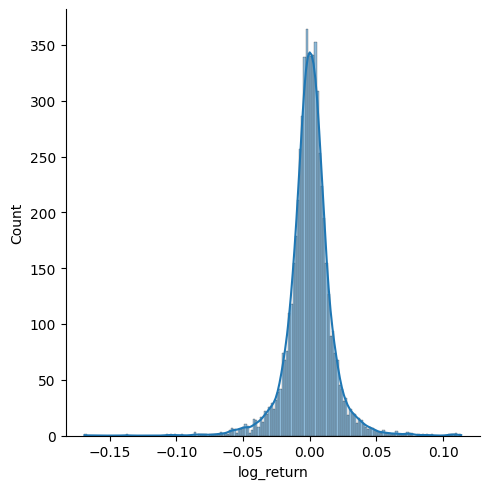

In [18]:
# Ability to add Kernel density estimate (not sure why we need it but hey... => FAT TAILS)
sns.displot(data = df, x="log_return", kde=True)